# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [10]:
import pandas as pd
import numpy as np
file = pd.read_csv("995000_rows.csv", skiprows=range(1,700630), nrows=20)
# file = "sample.csv"'
# remove any rows that have any missing id 
file = file.dropna(subset=['id'])
file = file.dropna(subset=['content'])
file = file.dropna(subset=['type'])
# number of rows
file.head(100)
# comment

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
1,1443,7109289,beforeitsnews.com,fake,http://beforeitsnews.com/alternative/2013/02/s...,Six Common Reloading Myths\n\n(Before It's New...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Six Common Reloading Myths,NaN,NaN,[''],NaN,NaN,NaN,NaN
2,4062,829590,beforeitsnews.com,fake,http://beforeitsnews.com/outdoors/2011/10/high...,Warning: Beware the 1-31-18 Blood/Blue/Supermo...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,High Point Duke Energy Rate Hike Hearing Turns...,Appalachian Voices,NaN,[''],NaN,NaN,NaN,NaN
3,1158,3742438,beforeitsnews.com,fake,http://beforeitsnews.com/financial-markets/201...,Capital Markets ETFs For 2012? – ETF News And ...,2017-11-21T12:56:35.440396,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Capital Markets ETFs For 2012? – ETF News And ...,Zacks Investment Research,NaN,[''],NaN,NaN,NaN,NaN
4,4064,829593,beforeitsnews.com,fake,http://beforeitsnews.com/contributor/pages/54/...,18\n\nTo Outdoors on Friday May 04 2012 13:24,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Stories contributed by Women's Endurance Gear,NaN,NaN,[''],NaN,NaN,NaN,NaN
5,4065,829594,beforeitsnews.com,fake,http://beforeitsnews.com/contributor/pages/54/...,press\n\nBefore It's News ©\n\npeople powered ...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Women's Endurance Gear,NaN,NaN,[''],NaN,NaN,NaN,NaN
6,7314,9866655,nytimes.com,reliable,https://www.nytimes.com/2017/11/05/books/hotel...,Photo\n\nFor anyone who lived through the 1980...,2018-02-11 00:49:42.219009,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Tell Us 5 Things About Your Book: Miami During...,John Williams,NaN,"['Books and Literature', 'Miami (Fla)', 'Hotel...",Roben Farzad’s “Hotel Scarface” recounts the w...,NaN,NaN,nytimes
7,4067,829596,dailykos.com,political,https://www.dailykos.com/news/blockedsites,"Melania May Be Trolling Trump And If So, It's ...",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Daily Kos: blockedsites,"Happy Cog Studios - Http, Www.Happycog.Com, Da...",NaN,[''],NaN,Next,NaN,NaN
8,4966,1892406,washingtonexaminer.com,political,http://www.washingtonexaminer.com/manhattan-mo...,"In terms of economics, the Supreme Court's rul...",2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Manhattan Moment: The birth control mandate is...,Jared Meyer,NaN,"['Contraception', 'Manhattan Moment', 'Healthc...","In terms of economics, the Supreme Court's rul...",NaN,NaN,NaN
9,3265,7997905,www.theatlantic.com,reliable,http://www.theatlantic.com/notes/2016/11/bubbl...,My colleague Andrew McGill wrote a punchy piec...,2016-11-22T00:12:58.319+02:00,2018-02-10 13:43:39.521661,2018-02-10 13:43:39.521686,Will Liberal Bubble Burst? Your Thoughts,theatlantic.com,NaN,NaN,NaN,NaN,NaN,webhose
10,3876,2131961,freedomdaily.com,fake,https://freedomdaily.com/watch-thug-gets-buste...,"Sometimes, to prevent something bad from happe...",2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,WATCH: Thug Gets BUSTED Shoplifting… What They...,"Jeff Rainforth, Kat Stevens, Frank Lea",NaN,[''],NaN,funny,NaN,NaN


In [11]:
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.lm import Vocabulary
from nltk.probability import FreqDist
from functools import reduce
from cleantext import clean

def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
  # flatten the list of tokens
  # use update instead of + to avoid creating a new list each time
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)

  return fq

# def build_vocabulary(df_tokens):
#   # flatten the list of tokens
#   tokens = []
#   for lst in df_tokens:
#     tokens += lst
#   vocabulary = Vocabulary(tokens, unk_cutoff=1)
#   return vocabulary


[nltk_data] Downloading package punkt to /home/william/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/william/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# df = pd.read_csv(file)
df = file
clean_df = df.copy()

clean_df.content = clean_df.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
clean_df["tokenized"] = clean_df.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(clean_df.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

clean_df.tokenized = clean_df.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(clean_df.tokenized)
# reduction rate of the vocabulary size
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")

clean_df.tokenized = clean_df.tokenized.apply(stem_tokens)
vocab = build_vocabulary(clean_df.tokenized)
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")
print(len(nltk.corpus.stopwords.words('english')))
print(nltk.corpus.stopwords.words('english'))

# make tokenize colum into a string with whitespace separator

After cleaning:
vocabulary size: 7239

After removing stopwords:
vocabulary size: 7111
reduction rate of the vocabulary size: 128 words

After stemming:
vocabulary size: 5124
reduction rate of the vocabulary size: 1987 words

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',


1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  plt.yticks(range(0, max(all_freq.values())+1, 300))
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq1(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  plt.figure(figsize=(5, 16))
  plt.xticks(rotation=90,)
  sns.barplot(x = list(all_freq.values()), y = list(all_freq.keys()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Frequency')
  plt.ylabel('Words')
  plt.show()
  return

Number of URLs in the content: 3
Number of dates in the content: 27
Number of numerics in the content: 366


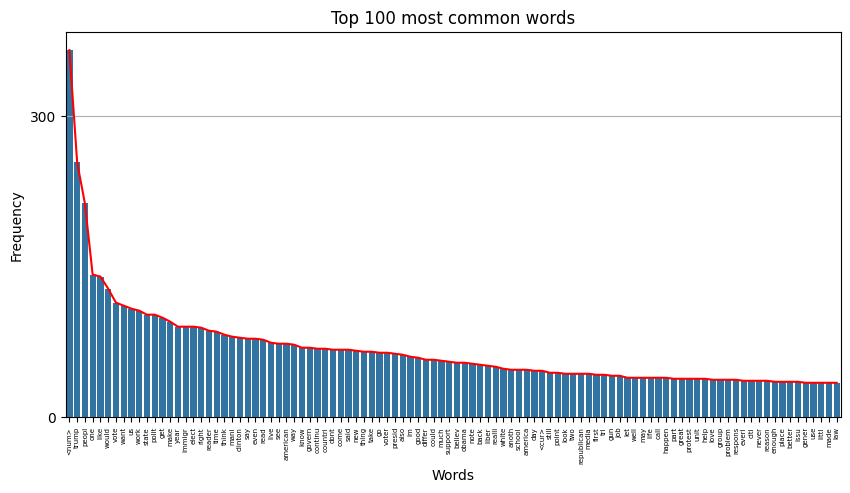

In [15]:

url_freq = vocab.get("<url>",0)
date_freq = vocab.get("<date>",0)
num_freq = vocab.get("<num>",0)
print(f"Number of URLs in the content: {url_freq}")
print(f"Number of dates in the content: {date_freq}")
print(f"Number of numerics in the content: {num_freq}")

plot_freq(vocab, 100)
#plot_freq1(vocab, 100)


In [16]:
#Task 3

In [17]:
import pandas as pd

# df = pd.read_csv('995,000_rows.csv')


# Task 4

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


df = pd.read_csv('news_sample.csv')
clean_df = df.copy()

clean_df.content = clean_df.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
clean_df["tokenized"] = clean_df.content.apply(tokenizer.tokenize)
clean_df.tokenized = clean_df.tokenized.apply(rmv_stopwords)
clean_df.tokenized = clean_df.tokenized.apply(stem_tokens)


select_types = ['fake', 'conspiracy', 'junksci', 'reliable', 'political', 'clickbait']
unreliable_types = ['fake', 'conspiracy', 'junksci']

# remove types that arent in select_types
clean_df = clean_df[clean_df['type'].isin(select_types)]
clean_df['bool'] = clean_df['type'].apply(lambda type: 0 if type in unreliable_types else 1)

clean_df.tokenized = clean_df['tokenized'].apply(lambda tokens: ' '.join(tokens))

X = clean_df['tokenized']
y = clean_df['bool']

train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio) #add random state - giver samme split hver gang?

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) #add random state?

print(len(clean_df['tokenized']))

# Vectorization
vectorizer = TfidfVectorizer()
xv_train = vectorizer.fit_transform(x_train)
xv_val = vectorizer.transform(x_val)
xv_test = vectorizer.transform(x_test)

model = LogisticRegression()
model.fit(xv_train, y_train)

test_pred = model.predict(xv_test)

accuracy_test = accuracy_score(y_test, test_pred)
print(f'Accuracy of logistic regression classifier on test set: {accuracy_test:.2f}')
print(classification_report(y_test, test_pred))


219
Accuracy of logistic regression classifier on test set: 0.82
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       0.00      0.00      0.00         4

    accuracy                           0.82        22
   macro avg       0.41      0.50      0.45        22
weighted avg       0.67      0.82      0.74        22



/home/william/miniconda3/envs/my_enviroment/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/william/miniconda3/envs/my_enviroment/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/william/miniconda3/envs/my_enviroment/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo